In [33]:
using DelimitedFiles
using PyPlot

In [42]:
# Col 1: 3-5-AMP concentration (mM);
# Col 2: overall rate (micro-M/h);
# Col 3: 95% confidence estimate of measured rate

data_array = readdlm("./Data-3-5-AMP.txt")

amp_conc = data_array[:,1] # mM
overall_rate = data_array[:,2]*1e-3; # mM/h
errs = data_array[:,3]*1e-3; # mM/h


In [35]:
# Given data

kcat = 0.4*3600 # 1/h
E1 = 0.12e-3 # mM
conc_F6P = 0.1 # mM
conc_ATP = 2.3 # mM
K_F6P = 0.11 # mM
K_ATP = 0.42 # mM

r1 = kcat*E1*(conc_F6P/(conc_F6P + K_F6P))*(conc_ATP/(conc_ATP + K_ATP));

In [36]:
function simulate_lacZ_expression(r,W1,W2,Kd,n)

    # initialize -
    lacZ_sim_array = zeros(1000,3)

    # setup inducer range -
    I_range = exp10.(range(-5,0,length=1000))

    # compute -
    for (index,i_val) in enumerate(I_range)
        
        # grab inducer level -
        lacZ_sim_array[index,1] = i_val
        
        # compute u -
        f_val = (i_val^n)/(Kd^n+i_val^2)
        u_value = (W1+W2*f_val)/(1+W1+W2*f_val)

        # compute mRNA 
        lacZ_sim_array[index,2] = r*u_value

        # grab u -
        lacZ_sim_array[index,3] = u_value
    end

    # return -
    return lacZ_sim_array, I_range
end

simulate_lacZ_expression (generic function with 1 method)

In [37]:
# estimate W1 -
alpha = (overall_rate[1]/r1);    # m(I=0)/K = W1/(1+W1)
W1 = (alpha)/(1-alpha);

# estimate W2 -
# saturates at I = 0.216 => assume fI ~ 1 => we can solve for W2 directly u = 0.99
u_sat = 0.99;
W2 = (1/(1-u_sat))*(u_sat+(u_sat - 1)*W1);

In [38]:
println("W1 : ", W1)
println("W2 : ", W2)

W1 : 0.04510578098748108
W2 : 98.95489421901243


In [39]:
# how do we get Ki and n?
# we can estimate these by least-squares (correct way), or just fiddle w/them based on estimates -
Ki = 9e-2   # units: mM
n = 4.40    # units: dimensionless
sim_array_lacZ = simulate_lacZ_expression(r1,W1,W2,Ki,n);

println("Ki: ", Ki)
println("n: ", n)

Ki: 0.09
n: 4.4


In [40]:
# Calculate rate

# allosteric control variable
v = sim_array_lacZ[1][:,3];

# rate
r_hat= r1*v;

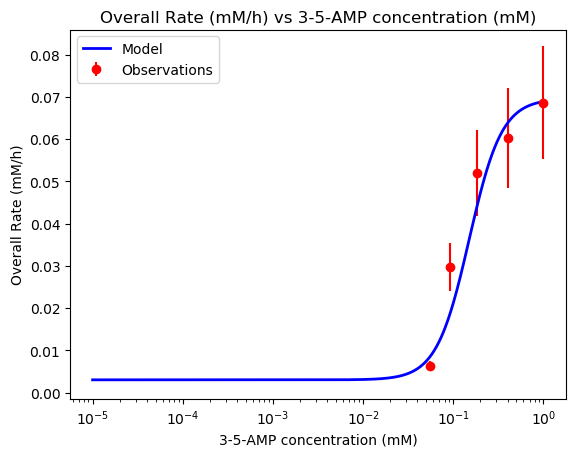

In [41]:
figure();
semilogx(sim_array_lacZ[1][:,1],r_hat,"b",lw=2, label="Model");
errorbar(amp_conc, overall_rate, yerr=errs, fmt="ro", label="Observations")
legend(loc=2)
xlabel("3-5-AMP concentration (mM)");
ylabel("Overall Rate (mM/h)");
title("Overall Rate (mM/h) vs 3-5-AMP concentration (mM)");

savefig("./plot4c.png")
